## Loading packages

In [1]:
from genepy.utils import helper as h

# to comment in your case
from taigapy import TaigaClient
tc = TaigaClient()

from celligner import Celligner
import pandas as pd
# to comment in your case
from depmapomics import tracker as track
#autoreload
%load_ext autoreload
%autoreload 2
#output
from bokeh.plotting import output_notebook
output_notebook()

from celligner.params import TISSUE_COLOR

/home/jeremie/celligner/celligner/mnnpy/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7fe7383812f0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/jeremie/miniconda3/lib/python3.7/site-packages/numba/core/typing/templates.py:722

During: resolving callee type: Function(<function norm at 0x7fe7383812f0>)
During: typing of call at /home/jeremie/celligner/celligner/mnnpy/mnnpy/utils.py (16)


File "../celligner/mnnpy/mnnpy/utils.py",

Cython module _utils not initialized. Fallback to python.


Loading BokehJS ...

## Loading expression files

In [7]:
# load from taiga public (figshare link)
# load internal expression,
# latest version can be found at https://depmap.org/portal/download/
# can also be loaded like so pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_expression.csv.gz', index_col=0)
CCLE_expression = tc.get(name='internal-22q1-1778',
                         file='CCLE_expression_full')  

# load  TCGA expression
# this dataset was generated from  ,using this script: 
# caan be found here: pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_expression.csv.gz', index_col=0)
TCGA_expression = tc.get(name='celligner-input-9827',
                         file='tumor_expression')

No dataset version provided. Using version 24.


[##################]100% |  30.5 MiB/s | 173.4 MiB / 173.4 MiB | Time:  0:00:05


No dataset version provided. Using version 1.


In [8]:
# subset gene names to ensembl ids only
CCLE_expression = CCLE_expression[CCLE_expression.columns[:-92]]
CCLE_expression.columns = list(map(lambda x: x.split(
    ' (')[1][:-1] if ' (' in x else x, CCLE_expression.columns))

common = set(CCLE_expression.columns).intersection(
    set(TCGA_expression.columns))
CCLE_expression = CCLE_expression[list(common)]
TCGA_expression = TCGA_expression[list(common)]

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Managing annotations

In [9]:
# loading annotations
CCLE_annotation = track.getTracker() # the function uses pygsheets to load this: REFSHEET_URL=https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY
# Sheets.from_files(MY_ID, MYSTORAGE_ID).get(REFSHEET_URL).sheets[0].to_frame(index_col=0)
# you can also get it from pd.read_csv('gs://ccle_default_params/celligner_ex/CCLE_annotation.csv.gz', index_col=0)


# can be loaded from 
# pd.read_csv('gs://ccle_default_params/celligner_ex/TCGA_annotation.csv.gz', index_col=0)
TCGA_annotation = tc.get(name='celligner-input-9827',
                         file='tumor_annotations') # generated manually 

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/jeremie/miniconda3/lib/python3.7/site-packages/uritemplate/variable.py:363: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return isinstance(value, (dict, collections.MutableMapping))
/home/jeremie/miniconda3/lib/python3.7/site-packages/googleapiclient/_helpers.py:130: ResourceWarning: unclosed <ssl.SSLSocket fd=47, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.142.0.3', 50228), raddr=('173.194.217.95', 443)>
  return wrapped(*args, **kwargs)


No dataset version provided. Using version 1.


In [10]:
# transforming annotations
CCLE_annotation = CCLE_annotation.drop_duplicates('arxspan_id').set_index("arxspan_id")
CCLE_annotation = CCLE_annotation.loc[CCLE_expression.index, ["lineage", 'subtype']].rename(columns={"lineage": "tissue_type", "subtype": 'disease_type'})
CCLE_annotation["cell_type"] = "CCLE cell line"

TCGA_annotation = TCGA_annotation.set_index("sampleID").loc[TCGA_expression.index,["lineage",
"subtype"]].rename(columns={"lineage":"tissue_type", "subtype": 'disease_type'})
TCGA_annotation['cell_type'] = "TCGA tumor"

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
rename = {np.nan: "unknown", "adrenal_cortex": "adrenal", "colorectal": "colon", 'thymus': 'thyroid', 'meninges':"central_nervous_system", None: "unknown", 'brain': "central_nervous_system"}

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# some name are not consistent between the two datasets
CCLE_annotation = CCLE_annotation.replace({"tissue_type": rename})
TCGA_annotation = TCGA_annotation.replace({"tissue_type": rename})

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Fitting celliner with the CCLE dataset 

In [23]:
my_alligner = Celligner(make_plots=True, priotize_fit=True)
my_alligner.fit(CCLE_expression, CCLE_annotation)

fetching gene names from biomart cache
using only usefull genes
looking at 1460 samples.
found 29567 common genes
creating a fit dataset..
clustering...
         Falling back to preprocessing with `sc.pp.pca` and default params.
reducing dimensionality...


doing differential expression analysis on the clusters
running differential expression on 38 clusters
running limmapy on the samples
you need to have R installed with the limma library installed
3.4.5
done


In [ ]:
my_alligner.method = "mnn_marioni"
my_alligner.priotize_fit=True
my_alligner.mnn_kwargs = {'k1': 5, 'k2': 50, 'cosine_norm': False, "fk":5}
_ = my_alligner.transform(TCGA_expression, TCGA_annotation)

In [27]:
my_alligner.plot(color_column="tissue_type", colortable=TISSUE_COLOR, umap_kwargs={'n_neighbors': 10,'min_dist': 0.3, 'metric': 'euclidean'})

reducing dimensionality...
making plot...


Figure(id='1956', ...)

## adding other datasets to celligner

for additional explanation on the dataset pre processing : [DepMap Portal: Celligner multidataset documentation](https://docs.google.com/document/d/1PW5GUwqLKj63pqOpi0r7r-9hXVQokSngPHiGWXp4q20/edit)

In [14]:
# met500 
met500_ann = tc.get(name='met500-fc3c', file='met500_ann')
met500_meta = tc.get(name='met500-fc3c', file='met500_meta')
met500_TPM = tc.get(name='met500-fc3c', file='met500_TPM') #20,979x868 matrix

#Novartis_PDX
Novartis_PDX_ann = tc.get(name='pdx-data-3d29', file='Novartis_PDX_ann')
Novartis_PDX_TPM = tc.get(name='pdx-data-3d29', file='Novartis_PDX_TPM').T # 38,087x445

#pediatric_PDX
pediatric_PDX_ann = tc.get(name='pdx-data-3d29', file='pediatric_PDX_ann')
pediatric_PDX_TPM = tc.get(name='pdx-data-3d29', file='pediatric_PDX_TPM') #80,000x250

No dataset version provided. Using version 1.
No dataset version provided. Using version 1.
No dataset version provided. Using version 1.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.
No dataset version provided. Using version 2.


### Managing annotations

In [15]:
met500_meta["primary_site"] = met500_ann['primary_site'].values
met500_ann = met500_meta.rename(columns={"Sample_id": 'sample_id', 'tissue': 'tissue_type', 'primary_site': "disease_type", "sample_type": "cell_type"}).set_index('sample_id', drop=True)[["tissue_type","disease_type","cell_type"]].replace({"tissue_type":rename, "cell_type": {"tumor": "met500 tumor"}})

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
pediatric_PDX_ann = pediatric_PDX_ann.rename(columns={"sampleID": 'sample_id', 'lineage': 'tissue_type', 'subtype': "disease_type", "type": "cell_type"}).set_index('sample_id', drop=True)[['cell_type', 'disease_type', 'tissue_type']].replace({"tissue_type":rename})

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
Novartis_PDX_ann = Novartis_PDX_ann.rename(columns={"sampleID": 'sample_id', 'lineage': 'tissue_type', 'subtype': "disease_type", "type": "cell_type"}).set_index('sample_id', drop=True)[['cell_type', 'disease_type', 'tissue_type']].replace({"tissue_type":rename})

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
pediatric_PDX_ann['cell_type'] = "ped PDX"

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# if you want to align to both CCLE and TCGA, you can ask celligner to consider the two (fit + _pre-transformed_ transform datasets) as a fit dataset by calling:
# my_alligner.putAllToFit()

# you can add your dataset as a dataset to be aligned to, by puting it in fit:
# my_alligner.addToFit(yourdataset).transform()
# /!\ need to already have a transform dataset (if you loaded the example model, this is TCGA)

# you can add your dataset as one to align, by putting it in transform:
# my_alligner.addToTransform(yourdataset)
# /!\ need to already have a fit dataset (if you loaded the example model, this is CCLE)

# if your dataset is small enough it might actually not work well to put it in transform it seems!
# if your dataset is small and similar enough, you can add the parameter dotransform=False (or dofit=False) so that it doesn't fully retransforms or refit but uses cached computation instead.
my_alligner.priotize_fit=False
my_alligner.putAllToFit(redo_diff=False)
my_alligner.mnn_kwargs.update({'k1': 20})
_ = my_alligner.transform(met500_TPM, met500_ann, recompute_contamination=False)

In [ ]:
set(Novartis_PDX_ann.index) ^ set(Novartis_PDX_TPM.index)

In [ ]:
Novartis_PDX_ann = Novartis_PDX_ann.loc[Novartis_PDX_TPM.index]

In [ ]:
my_alligner.putAllToFit(redo_diff=False)
my_alligner.mnn_kwargs.update({'k1': 10})
#_= my_alligner.transform(pd.concat([Novartis_PDX_TPM, pediatric_PDX_TPM]), pd.concat([Novartis_PDX_ann, pediatric_PDX_ann]), recompute_contamination=False)

_= my_alligner.transform(Novartis_PDX_TPM, Novartis_PDX_ann, recompute_contamination=False)

In [ ]:
my_alligner.putAllToFit(redo_diff=False)
_= my_alligner.transform(pediatric_PDX_TPM, pediatric_PDX_ann, recompute_contamination=False)

In [ ]:
from celligner.params import TISSUE_COLOR
my_alligner.plot(color_column="tissue_type", colortable=TISSUE_COLOR)

## saving and exporting

In [43]:
my_alligner.save('../temp/22Q1')

In [59]:
def exportCellignerToPortal(my_alligner):
    return pd.concat([my_alligner.annotations, pd.DataFrame(data=np.hstack([my_alligner.umap_reduced, np.array([my_alligner.clusts]).T]), index=my_alligner.annotations.index, columns=['umap1', 'umap2', 'clusts']),], axis=1)

In [62]:
exportCellignerToPortal(my_alligner).to_csv('../temp/22Q1/celligner_aligned_all.csv')

In [65]:
new_dataset_id = tc.update_dataset(
    "celligner-multi-dataset-alignment-5403",
    changes_description="new version for 22Q1 processed with the python celligner. columns are now [umap1, umap2, clusts, tissue_type, disease_type, cell_type]",
    upload_files=[
        {
            "path": "temp/22Q1/celligner_aligned_all.csv",
            "format": "TableCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    add_all_existing_files=False, # If True, will add all files from the base dataset version, except files with the same names as those in upload_files or add_taiga_ids
)

No dataset version provided. Using version 1.
Uploading celligner_aligned_all to S3
Finished uploading celligner_aligned_all to S3
Uploading celligner_aligned_all to Taiga
Finished uploading celligner_aligned_all to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/1de28b8b7cc4486d8909f2507c6eff8b


## making it portal-like

In [3]:
my_alligner = Celligner()
my_alligner.load('../temp/22Q1')

fetching gene names from biomart cache
using only usefull genes


In [12]:
set(my_alligner.annotaticell_typecell_type)

{'CCLE cell line', 'PDX', 'TCGA tumor', 'met500 tumor', 'ped PDX'}

In [17]:
imp = np.zeros(len(my_alligner.umap_reduced))
imp[my_alligner.annotations.cell_type=="TCGA tumor"] = 2
my_alligner.plot(rerun=False, importance = imp)

making plot...


Figure(id='1965', ...)

In [28]:
my_alligner.plot(color_column="tissue_type", colortable=TISSUE_COLOR, rerun=False, shape=my_alligner.annotations.cell_type.values)

making plot...


Figure(id='2691', ...)

In [39]:
nn = my_alligner.getKNN(ofcell="CCLE cell line", incell="TCGA tumor")

In [40]:
nn

0                1                2  \
ACH-001113  TCGA-77-8009-01  TCGA-58-A46M-01  TCGA-22-4599-01   
ACH-001289    TH02_0096_S01  TCGA-26-5134-01    TH02_0088_S01   
ACH-001339  TCGA-FS-A1Z7-06  TCGA-BF-A3DN-01  TCGA-ER-A2NH-06   
ACH-001538  TCGA-K4-A6FZ-01  TCGA-E7-A97P-01  TCGA-VS-AA62-01   
ACH-000242  TCGA-DK-A6B6-01  TCGA-GV-A3QK-01  TCGA-CF-A47X-01   
...                     ...              ...              ...   
ACH-000285   THR09_0562_S01   THR09_0577_S01   THR09_0221_S01   
ACH-002669  TCGA-AM-5821-01  TCGA-35-4122-01  TCGA-BR-8366-01   
ACH-001858  TCGA-AN-A0XN-01  TCGA-AC-A23E-01  TCGA-E2-A153-01   
ACH-001997  TCGA-IB-A7M4-01  TCGA-HV-A7OL-01  TCGA-IN-A7NU-01   
ACH-000052   THR30_0826_S01   THR30_0844_S01   THR30_0806_S01   

                          3                    4    dist0    dist1    dist2  \
ACH-001113  TCGA-43-A475-01      TCGA-O2-A52S-01  87.6507   92.879  100.063   
ACH-001289   THR24_2023_S01  TARGET-50-PAKKNS-01  143.672  144.191  145.088   
ACH-001339   THR24_2079_S01      TCGA-D3-A3MV-06  90.3733  94.3432  98.9906   
ACH-001538  TCGA-XF-AAN3-01      TCGA-FD-A6TD-01  116.386  116.715  118.247   
ACH-000242  TCGA-UY-A78O-01      TCGA-4Z-AA7S-01  73.6432  74.0157  74.8632   
...                     ...                  ...      ...      ...      ...   
ACH-000285   THR09_0575_S01       THR22_0604_S01  111.276  113.185  114.221   
ACH-002669  TCGA-55-8208-01      TCGA-BR-6706-01  122.393  123.951  125.144   
ACH-001858  TCGA-E9-A22E-01      TCGA-E9-A1NG-01  81.0824  91.8578  91.9989   
ACH-001997  TCGA-AZ-6607-01      TCGA-D7-6525-01  116.636  117.288   117.52   
ACH-000052   THR30_0820_S01       THR30_0841_S01  101.764  103.668  104.127   

              dist3    dist4                    pred prob  
ACH-001113  101.979  103.916                    lung    1  
ACH-001289   150.03   151.07  central_nervous_system  0.8  
ACH-001339  101.604  101.661                    skin    1  
ACH-001538  118.379  118.476           urinary_tract  0.8  
ACH-000242  79.3082  80.1348           urinary_tract    1  
...             ...      ...                     ...  ...  
ACH-000285  115.396  115.655              lymphocyte    1  
ACH-002669  126.512  126.543                   colon  0.2  
ACH-001858  92.1629  92.5307                  breast    1  
ACH-001997  118.436  119.139                pancreas  0.4  
ACH-000052  105.237  105.942                    bone    1  

[1460 rows x 12 columns]

## computing metrics 

In [23]:
import scib
from anndata import AnnData

In [107]:
adata = AnnData(my_alligner.fit_input.append(my_alligner.transform_input), my_alligner.fit_annotations.append(my_alligner.transform_annotations))

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
common = set(CCLE_expression.columns) & set(met500_TPM.columns) & set(Novartis_PDX_TPM.columns) & set(pediatric_PDX_TPM.columns)
CCLE_expression = CCLE_expression[list(common)]
TCGA_expression = TCGA_expression[list(common)]
met500_TPM = met500_TPM[list(common)]
Novartis_PDX_TPM = Novartis_PDX_TPM[list(common)]
pediatric_PDX_TPM = pediatric_PDX_TPM[list(common)]
len(common)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18063

In [33]:
data = pd.concat([CCLE_expression, TCGA_expression, met500_TPM, Novartis_PDX_TPM, pediatric_PDX_TPM])

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
obs = my_alligner.fit_annotations.append(my_alligner.transform_annotations)
obs = obs[~obs.index.isin({'ACH-001481', 'ACH-002781', 'ACH-002794', 'ACH-002806'})]
data = data.loc[obs.index]
adata_unfit = AnnData(data,obs)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['tissue_type'] = adata.obs['tissue_type'].astype("category")

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## current model 2 dataset scib score

In [171]:
only_adata = adata[adata.obs.cell_type.isin(["CCLE cell line", 'TCGA tumor'])]
only_adata_unfit = adata_unfit[adata_unfit.obs.cell_type.isin(["CCLE cell line", 'TCGA tumor'])]

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
scib.metrics.metrics(only_adata_unfit, only_adata, batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         Falling back to preprocessing with `sc.pp.pca` and default params.
NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_0pndcqzy/input.mtx /tmp/lisi_0pndcqzy/
iLISI score...
/tmp/lisi_vm71vcar/input.mtx /tmp/lisi_vm71vcar/


0
NMI_cluster/label          0.755806
ARI_cluster/label          0.557197
ASW_label                  0.537879
ASW_label/batch            0.739478
PCR_batch                  0.987072
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.486170
graph_conn                 0.875529
kBET                            NaN
iLISI                      0.023182
cLISI                      0.975428
hvg_overlap                     NaN
trajectory                      NaN

## current model multi dataset scib score 

In [179]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['tissue_type'] = adata.obs['tissue_type'].astype('category')

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [181]:
scib.metrics.metrics(adata_unfit, adata, batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_haf1wp5k/input.mtx /tmp/lisi_haf1wp5k/
iLISI score...
/tmp/lisi_ag85aqep/input.mtx /tmp/lisi_ag85aqep/


0
NMI_cluster/label          0.712650
ARI_cluster/label          0.501458
ASW_label                  0.515371
ASW_label/batch            0.788917
PCR_batch                  0.990319
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.474467
graph_conn                 0.804895
kBET                            NaN
iLISI                      0.018926
cLISI                      0.986651
hvg_overlap                     NaN
trajectory                      NaN

## Allie's model multi dataset scib score

In [201]:
celligner_aligned_all_data = tc.get(name='celligner-multi-dataset-alignment-5403', version=1, file='Celligner_aligned_all_data')
celligner_all_data = tc.get(name='celligner-multi-dataset-alignment-5403', version=1, file='Celligner_all_data')

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [203]:
celligner_all_data = celligner_all_data.loc[set(adata.obs.index) & set(celligner_all_data.index)]
celligner_aligned_all_data = celligner_aligned_all_data.T.loc[celligner_all_data.index]
celligner_aligned_all_data = celligner_aligned_all_data[set(celligner_aligned_all_data.columns) & set(adata.var.index)]

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [206]:
allie_aligner_adata = AnnData(celligner_aligned_all_data.values, obs = celligner_all_data, var = celligner_aligned_all_data.columns.tolist())

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [207]:
allie_aligner_adata.var.set_index(0, drop=True, inplace=True)

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [208]:
allie_aligner_adata.obs['cell_type'] = adata.obs.cell_type.astype('category')
allie_aligner_adata.obs['tissue_type'] = adata.obs['tissue_type'].astype('category')

/home/jeremie/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
scib.metrics.metrics(adata_unfit, allie_aligner_adata, batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_c_0ypqxs/input.mtx /tmp/lisi_c_0ypqxs/
iLISI score...
/tmp/lisi_js0u2tuv/input.mtx /tmp/lisi_js0u2tuv/


0
NMI_cluster/label          0.729241
ARI_cluster/label          0.501102
ASW_label                  0.499479
ASW_label/batch            0.823860
PCR_batch                  0.880661
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.463618
graph_conn                 0.773583
kBET                            NaN
iLISI                      0.042922
cLISI                      0.988616
hvg_overlap                     NaN
trajectory                      NaN

## Allie's model 2 dataset scib score

In [21]:
suballie_aligner_adata = allie_aligner_adata[allie_aligner_adata.obs.cell_type.isin(['CCLE cell line', 'TCGA tumor'])]

In [26]:
scib.metrics.metrics(adata_unfit[suballie_aligner_adata.obs.index], suballie_aligner_adata, batch_key="cell_type", label_key='tissue_type', cell_cycle_=False, organism='human', trajectory_=False, isolated_labels_asw_=True, silhouette_=True, hvg_score_=False, graph_conn_=True, pcr_=True, isolated_labels_f1_=False, nmi_=True, ari_=True, kBET_=True, ilisi_=True, clisi_=True,)

Trying to set attribute `.obs` of view, copying.


NMI...
ARI...
Silhouette score...
PC regression...
Isolated labels ASW...
Graph connectivity...
kBET...
cLISI score...
/tmp/lisi_j_vusx3l/input.mtx /tmp/lisi_j_vusx3l/
File has no entries. Doing nothing.
2316 has not enough neighbors.
iLISI score...
/tmp/lisi_l6zwc1po/input.mtx /tmp/lisi_l6zwc1po/
File has no entries. Doing nothing.
2316 has not enough neighbors.
13298 has not enough neighbors.


0
NMI_cluster/label          0.754255
ARI_cluster/label          0.534507
ASW_label                  0.525267
ASW_label/batch            0.776962
PCR_batch                  0.892280
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.462455
graph_conn                 0.840944
kBET                            NaN
iLISI                      0.042202
cLISI                      0.971766
hvg_overlap                     NaN
trajectory                      NaN

In [3]:
import scanpy as sc
from anndata import read_h5ad

In [236]:
allie_aligner_adata.write('../temp/allie_aligner_adata.h5ad.gz', compression='gzip')
adata_unfit.write('../temp/adata_unfit.h5ad.gz', compression='gzip')
adata.write('../temp/adata.h5ad.gz', compression='gzip')

... storing 'tissue_type' as categorical
... storing 'disease_type' as categorical
... storing 'cell_type' as categorical
... storing 'disease_type' as categorical


In [25]:
allie_aligner_adata = read_h5ad('../temp/allie_aligner_adata.h5ad.gz')
adata_unfit = read_h5ad('../temp/adata_unfit.h5ad.gz')
adata = read_h5ad('../temp/adata.h5ad.gz')

In [7]:
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(10, 10))
#torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

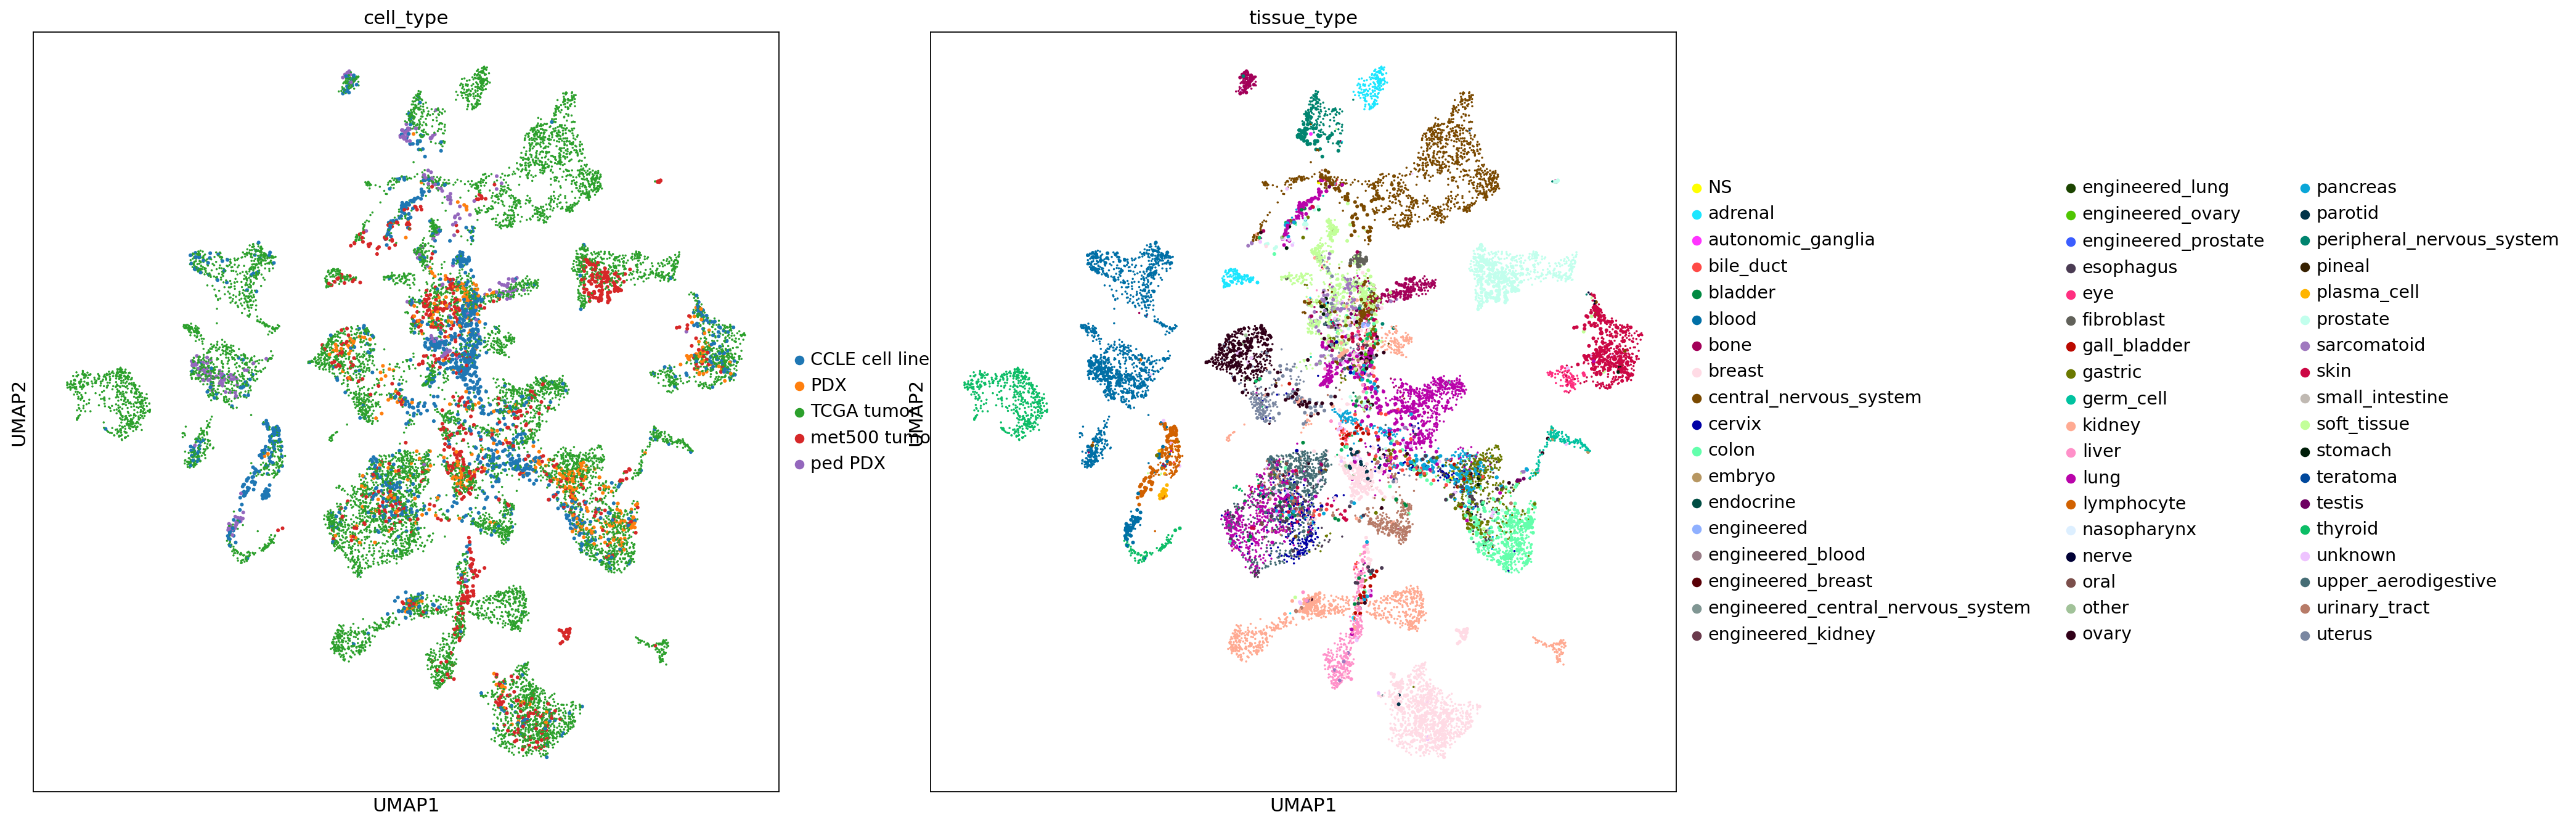

In [12]:
sc.pp.neighbors(allie_aligner_adata, n_neighbors=8)
sc.tl.umap(allie_aligner_adata, min_dist=0.5,
                            alpha=1,
                            spread=1)
sc.pl.umap(allie_aligner_adata,
        color=['cell_type', 'tissue_type'],
        projection="2d",
        size = [30 if val != 'TCGA tumor' else 10 for val in allie_aligner_adata.obs['cell_type']])

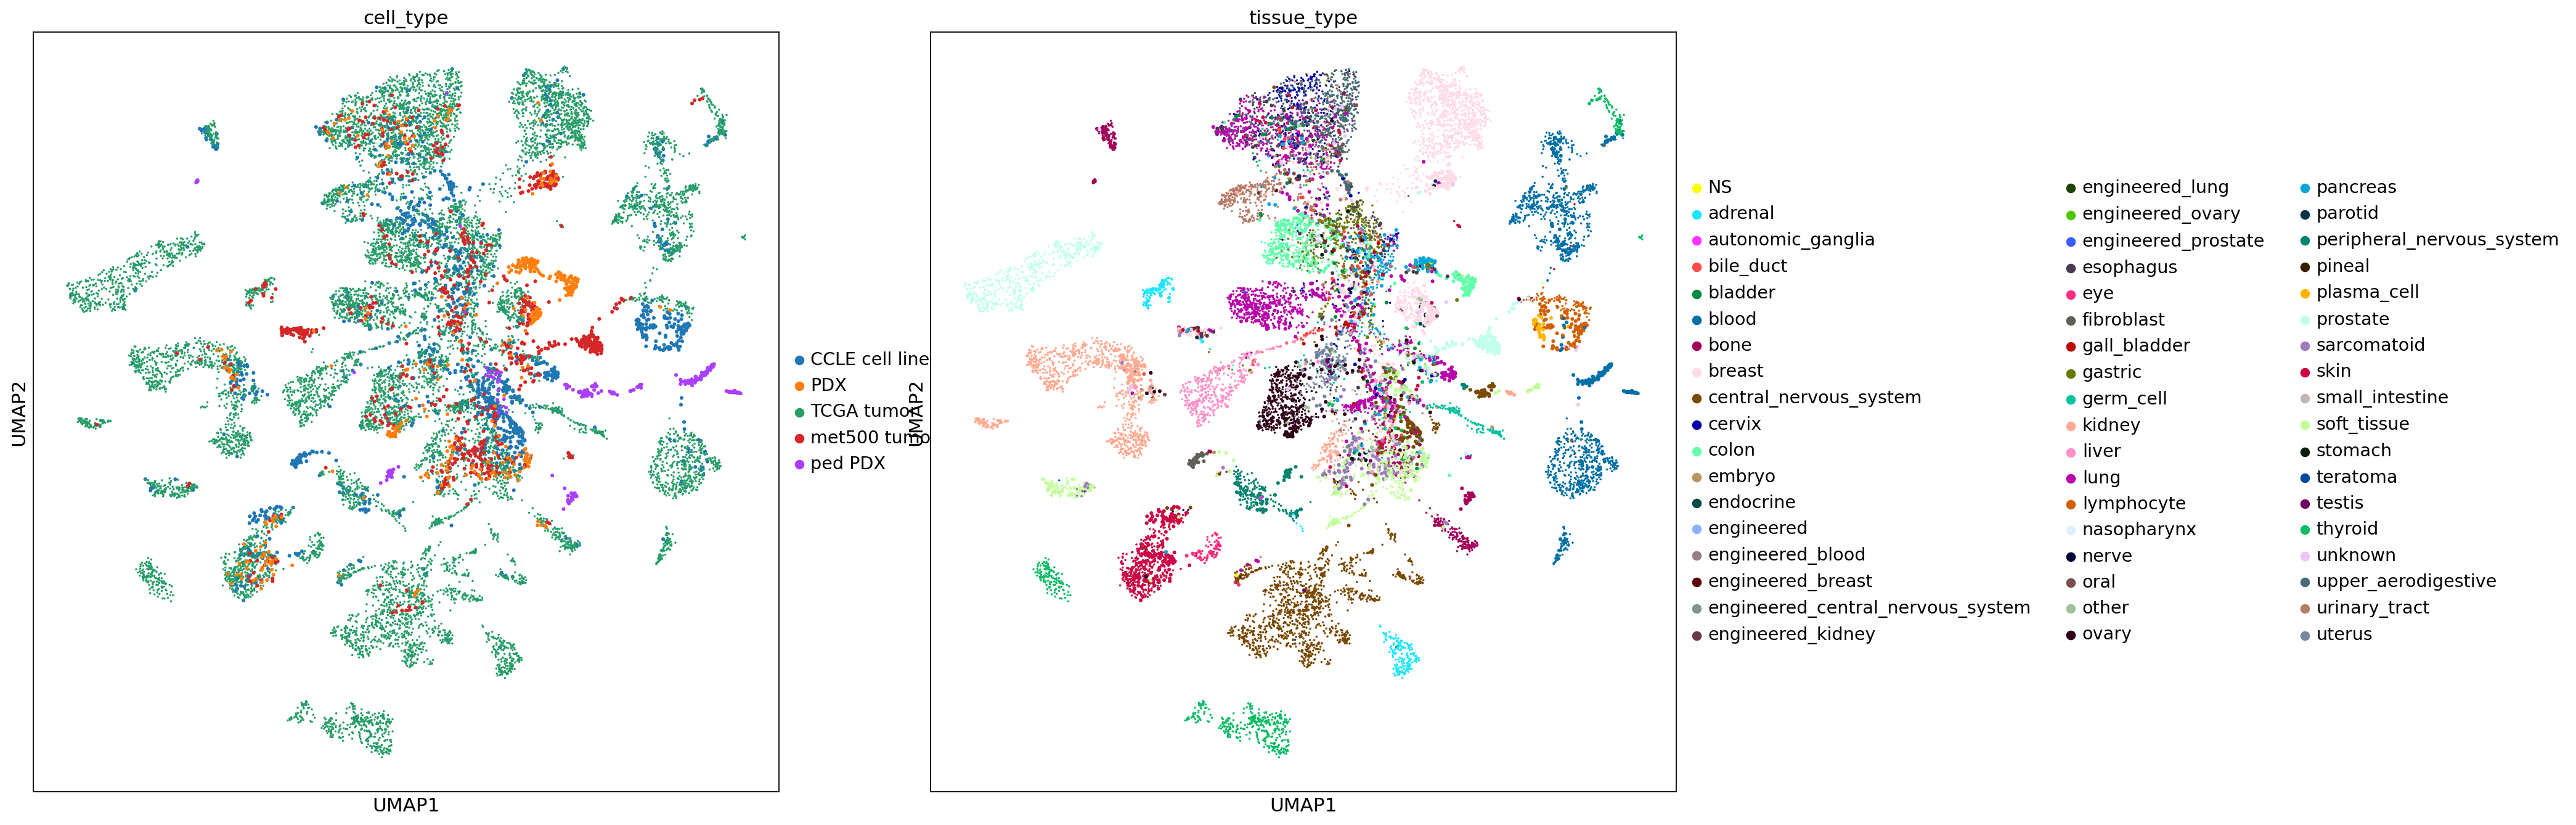

In [20]:
#sc.pp.neighbors(adata, n_neighbors=8)
#sc.tl.umap(adata, min_dist=0.5,
#                            alpha=1,
#                            spread=1)
sc.pl.umap(adata,
        color=['cell_type', 'tissue_type'],
        projection="2d",
        size = [30 if val != 'TCGA tumor' else 10 for val in adata.obs['cell_type']])